In [2]:
import pandas as pd
import numpy as np

In [27]:
listings = pd.read_csv('Listings.csv', low_memory=False, encoding="ISO-8859-1", parse_dates=["host_since"])
reviews = pd.read_csv('Reviews.csv')

In [28]:
listings.head(3)

,listing_id,name,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,...,minimum_nights,maximum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable
0,281420,"Beautiful Flat in le Village Montmartre, Paris",1466919,2011-12-03,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,...,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f
1,3705183,39 mÃÂ² Paris (Sacre CÃ âur),10328771,2013-11-29,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,...,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f
2,4082273,"Lovely apartment with Terrace, 60m2",19252768,2014-07-31,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,...,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f


In [29]:
reviews.head(3)

,listing_id,review_id,date,reviewer_id
0,11798,330265172,2018-09-30,11863072
1,15383,330103585,2018-09-30,39147453
2,16455,329985788,2018-09-30,1125378


## **Data Cleaning**

In [30]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279712 entries, 0 to 279711
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   listing_id                   279712 non-null  int64         
 1   name                         279537 non-null  object        
 2   host_id                      279712 non-null  int64         
 3   host_since                   279547 non-null  datetime64[ns]
 4   host_location                278872 non-null  object        
 5   host_response_time           150930 non-null  object        
 6   host_response_rate           150930 non-null  float64       
 7   host_acceptance_rate         166625 non-null  float64       
 8   host_is_superhost            279547 non-null  object        
 9   host_total_listings_count    279547 non-null  float64       
 10  host_has_profile_pic         279547 non-null  object        
 11  host_identity_verified    

#### Objective 1: (a) Filter the data down to rows where the city is Paris, and keep only the columns ‘host_since’, ‘neighbourhood’, ‘city’, ‘accommodates’, and ‘price’. (b) QA the Paris listings data: check for missing values, and calculate the minimum, maximum, and average for each numeric field

##### (a)

In [31]:
paris_listings = (listings
.query("city == 'Paris'")
.loc[:, ['host_since', 'neighbourhood', 'city', 'accommodates', 'price']]
)

paris_listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64690 entries, 0 to 279711
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   host_since     64657 non-null  datetime64[ns]
 1   neighbourhood  64690 non-null  object        
 2   city           64690 non-null  object        
 3   accommodates   64690 non-null  int64         
 4   price          64690 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 3.0+ MB


##### (b)

In [32]:
paris_listings.isna().sum()

,0
host_since,33
neighbourhood,0
city,0
accommodates,0
price,0


In [34]:
paris_listings.describe()

,host_since,accommodates,price
count,64657,64690.000000,64690.000000
mean,2015-11-01 11:06:05.528867584,3.037997,113.096445
min,2008-08-30 00:00:00,0.000000,0.000000
25%,2014-03-09 00:00:00,2.000000,59.000000
50%,2015-07-07 00:00:00,2.000000,80.000000
75%,2017-05-29 00:00:00,4.000000,120.000000
max,2021-02-07 00:00:00,16.000000,12000.000000
std,NaN,1.588766,214.433668


In [37]:
paris_listings.query('price == 0 and accommodates == 0').count()

,0
host_since,54
neighbourhood,54
city,54
accommodates,54
price,54


#### Objective 2: Prepare the data for visualization

##### (a) Create a table named paris_listings_neighbourhood that groups Paris listings by 'neighbourhood' and calculates the mean price (sorted low to high)

In [57]:
paris_listings_neighbourhood = (
    paris_listings
    .groupby('neighbourhood')
    .agg({'price': 'mean'})
    .sort_values('price')
)
paris_listings_neighbourhood.tail()

,price
neighbourhood,
Luxembourg,155.638639
Palais-Bourbon,156.856578
Passy,161.144635
Louvre,175.379972
Elysee,210.536765


##### (b) Create a table named paris_listings_accomodations, filter down to the most expensive neighborhood, group by the ‘accommodations’ column, and add the mean price for each value of ‘accommodates’ (sorted low to high)

In [61]:
paris_listings_accommodates = (
    paris_listings
    .query("neighbourhood == 'Elysee'")
    .groupby('accommodates')
    .agg({'price': 'mean'})
    .sort_values('price')
)
paris_listings_accommodates.head()

,price
accommodates,
0,0.000000
1,79.522222
3,152.828767
2,155.103352
4,212.096070


##### (c) Create a table called paris_listings_over_time grouped by the ‘host_since’ year, and calculate the average price and count of rows representing the number of new hosts

In [64]:
paris_listings_over_time = (
    paris_listings
    .set_index('host_since')
    .resample('Y')
    .agg({
        'neighbourhood': 'count',
        'price': 'mean'
    })
)
paris_listings_over_time.head()

/tmp/ipython-input-1277906691.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample('Y')


,neighbourhood,price
host_since,,
2008-12-31,4,77.750000
2009-12-31,106,159.641509
2010-12-31,416,125.031250
2011-12-31,1339,124.828230
2012-12-31,4592,111.578615


#### Ojbective 3: Visualize the data and summarize findings

##### (a) Create a horizontal bar chart of the average price by neighborhood in Paris, and make sure to add a title and change axis labels as needed

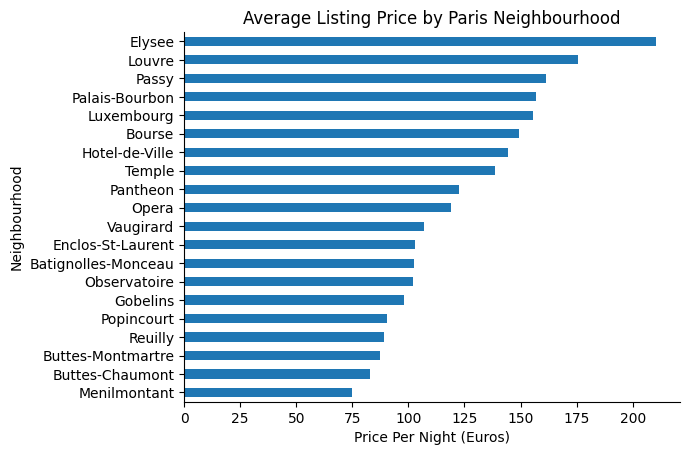

In [69]:
import seaborn as sns

(paris_listings_neighbourhood
 .plot.barh(
     title = 'Average Listing Price by Paris Neighbourhood',
     xlabel = 'Price Per Night (Euros)',
     ylabel = 'Neighbourhood',
     legend = None
 )
)

sns.despine()

##### (b) Create a horizontal bar chart of the average price by ‘accommodates’ in Paris’ most expensive neighborhood, and make sure to add a title and change axis labels as needed

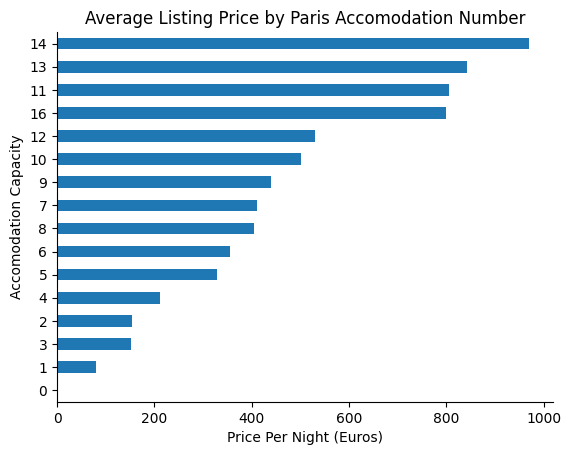

In [70]:
import seaborn as sns

(paris_listings_accommodates
 .plot.barh(
     title = 'Average Listing Price by Paris Accomodation Number',
     xlabel = 'Price Per Night (Euros)',
     ylabel = 'Accomodation Capacity',
     legend = None
 )
)

sns.despine()

##### (c) Create two line charts: one showing the count of new hosts over time, and one showing average price. Set the y-axis limit to 0, add a title, and change axis labels as needed

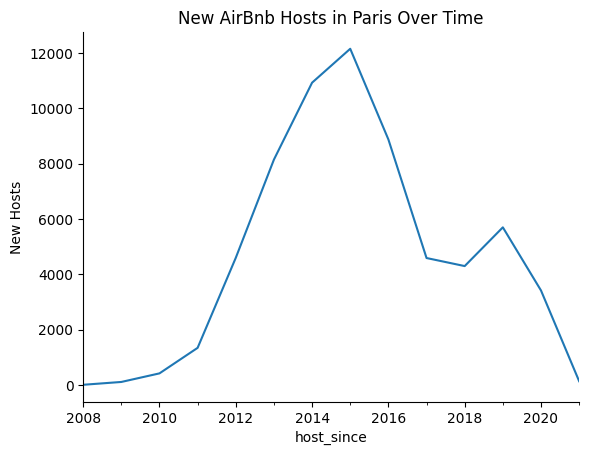

In [71]:
paris_listings_over_time['neighbourhood'].plot(
    ylabel = 'New Hosts',
    title = 'New AirBnb Hosts in Paris Over Time'
)
sns.despine()

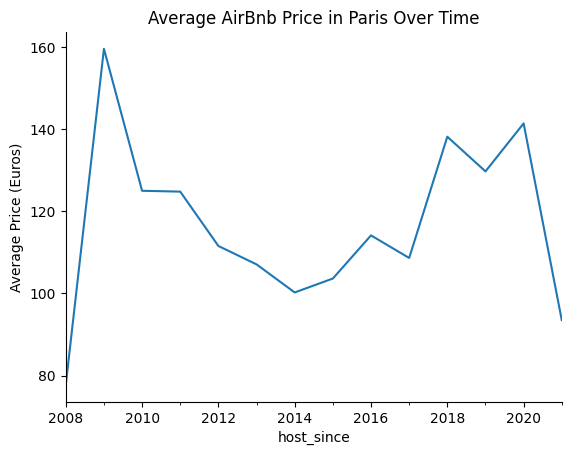

In [72]:
paris_listings_over_time['price'].plot(
    ylabel = 'Average Price (Euros)',
    title = 'Average AirBnb Price in Paris Over Time'
)
sns.despine()

##### (d) Based on your findings, what insights do you have about the impact of the 2015 regulations on new hosts and prices?

##### (e) Create a dual axis line chart to show both new hosts and average price over time

Text(0.5, 1.0, '2015 Regulations Lead to Fewer New Hosts, Higher Prices')

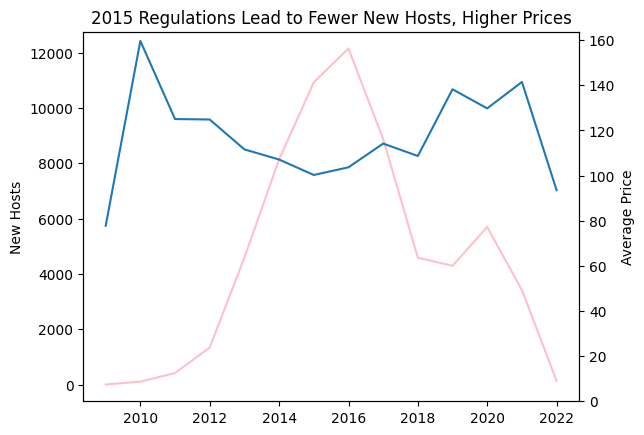

In [80]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(
   paris_listings_over_time.index,
   paris_listings_over_time['neighbourhood'],
   label = 'New Hosts',
   c = 'pink'

)

ax.set_ylabel('New Hosts')

ax2 = ax.twinx()

ax2.plot(
   paris_listings_over_time.index,
   paris_listings_over_time['price'],
   label = 'Average Price'

)
ax2.set_ylim(0)

ax2.set_ylabel('Average Price')

ax.set_title('2015 Regulations Lead to Fewer New Hosts, Higher Prices')